# Model Training experiments


In [408]:
%load_ext autoreload
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS

STATE = "SP"
WEEKS = True
TRIANGLE = True
PAST_UNITS = 7
MAX_DELAY = 7
BATCH_SIZE = 16

dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE)
## Define train and test indices
if WEEKS: # could also do random split, for now last indices as test
    train_idcs, test_idcs = range(300), range(300, dataset.__len__())
    TEST_BATCH_SIZE = dataset.__len__() - 300
else: 
    train_idcs, test_idcs = range(2500), range(2500, dataset.__len__())
    TEST_BATCH_SIZE = dataset.__len__() - 2500
train_sampler, test_sampler = SRS(train_idcs), SRS(test_idcs)
## Define train and test loader with SubsetRandomSampler over indices
#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
## Maybe make batch_size of test s.t. only one batch, one evaluation?
train_loader, test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/Thesis/src/data_functions.py:81: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


In [58]:
import numpy as np
import torch
from torch import nn
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time, device = "mps"):
        ''' Forward call of embedding module

        Args:
        time [torch.Tensor]: tensor of timesteps in batch

        Returns:
        PE [torch.Tensor]: embedding matrix        
        '''
        PE = torch.zeros(time.shape[0], self.dim, device=device)
        # Calculate the positional encodings
        for pos in range(time.shape[0]): 
            for i in range(self.dim):
                if i % 2 == 0: # should be 2*i and 2*i-1 as positions
                    PE[pos, i] = np.sin(np.exp(np.log(pos+1e-3) - (2 * i) / self.dim * np.log(10000))) # Add noise to avoid zero-division
                else: # Odd dimensions
                    PE[pos, i] = np.cos(np.exp(np.log(pos+1e-3) - (2 * i) / self.dim * np.log(10000)))
        # time contains all indices as slices
        return PE

class EarlyStopper:
    """ Class implementing early stopping. Theoretically, PyTorch lightning could be used, but this might be more rubust.
    
    As seen e.g. in https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch and adapted to include 
    restoration of best weights.
    """
    def __init__(self, patience = 30):
        self.patience = patience
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, val_loss, model):
        if val_loss < self.min_loss:
            self.min_loss = val_loss
            self.counter = 0
            ## Save best weights
            torch.save(model.state_dict(), f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-{('tri' if TRIANGLE else 'sum')}-{STATE}")
        elif val_loss > self.min_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    def get_count(self):
        return self.counter

In [478]:
import torch.nn as nn
import torch
from NegativeBinomial import NegBin as NB

## For matrix-like (two-dimensional) input data
class PNNTriangle(nn.Module):
    def __init__(self, past_units = 45, max_delay = 45, n_layers = 3, hidden_units = [64, 32, 16], n_conv = 4, conv_channels = [8, 4, 2, 1]):
        super().__init__()
        self.past_units = past_units
        self.max_delay = max_delay
        self.final_dim = past_units * (2**n_conv)
        self.conv1 = nn.ConvTranspose1d(self.max_delay, conv_channels[0], kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(conv_channels[0], conv_channels[1], kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose1d(conv_channels[1], conv_channels[2], kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose1d(conv_channels[2], conv_channels[3], kernel_size=4, stride=2, padding=1)
        self.fc1, self.fc2 = nn.Linear(self.past_units, self.past_units), nn.Linear(self.past_units, self.past_units)
        self.fc3, self.fc4, self.fc5 = nn.Linear(self.final_dim, hidden_units[0]), nn.Linear(hidden_units[0], hidden_units[1]), nn.Linear(hidden_units[1], hidden_units[2])
        self.fcnb = nn.Linear(hidden_units[2], 2)
        self.const = 10000

        self.bnorm1, self.bnorm2, self.bnorm3, self.bnorm4 = nn.BatchNorm1d(num_features=self.past_units), nn.BatchNorm1d(num_features=conv_channels[0]), nn.BatchNorm1d(num_features=conv_channels[1]), nn.BatchNorm1d(num_features=conv_channels[2])
        self.bnorm5, self.bnorm6, self.bnorm7, self.bnorm8 = nn.BatchNorm1d(num_features=self.final_dim), nn.BatchNorm1d(num_features=hidden_units[0]), nn.BatchNorm1d(num_features=hidden_units[1]), nn.BatchNorm1d(num_features=hidden_units[2])
        self.lnorm1 = nn.LayerNorm([self.max_delay])
        self.lnorm2 = nn.LayerNorm([self.max_delay])
        self.attn1 = nn.MultiheadAttention(embed_dim=self.past_units, num_heads=1, batch_first=True)
        #self.attn2 = nn.MultiheadAttention(embed_dim=self.past_units, num_heads=4, batch_first=True)
        self.drop1, self.drop2, self.drop3 = nn.Dropout(0.25), nn.Dropout(0.4), nn.Dropout(0.25)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        #print(f"Coming in: {x.size()}")
        
        #print(f"After conv layers: {x.size()}")
        x_add = x.clone()
        x = self.lnorm1(x)
        x = self.attn1(x, x, x, need_weights = False)[0]
        x = self.fc1(x)
        x = self.silu(x)
        #x = torch.squeeze(x)
        x = x + x_add
        """x_add = x.clone()
        #print(x.size())
        x = self.lnorm2(x)
        x = self.attn2(x, x, x, need_weights = False)[0]
        x = self.fc2(x)
        x = self.silu(x)
        x = x+x_add"""
        x = self.silu(self.conv1(self.bnorm1(x)))
        x = self.silu(self.conv2(self.bnorm2(x)))
        x = self.silu(self.conv3(self.bnorm3(x)))
        x = self.silu(self.conv4(self.bnorm4(x)))
        x = torch.squeeze(x)
        #print(f"After conv {x.size()}")
        x = self.silu(self.fc3(self.bnorm5(x)))
        x = self.drop1(x)
        x = self.silu(self.fc4(self.bnorm6(x)))
        x = self.drop2(x)
        x = self.silu(self.fc5(self.bnorm7(x)))
        x = self.drop3(x)
        x = self.fcnb(self.bnorm8(x))
        #dist = torch.distributions.Poisson(rate=1000*self.softplus(x))
        dist = NB(lbda = self.const*self.softplus(x[:, 0]), phi = self.const**2*self.softplus(x[:, 1])+1e-5)
        return torch.distributions.Independent(dist, reinterpreted_batch_ndims=1)

## For summed (one-dimensional) input data
class PNNSum(nn.Module):
    def __init__(self, past_units = 45, max_delay = 45, n_layers = 3, hidden_units = [64, 32, 16]):
        super().__init__()
        self.past_units = past_units
        self.max_delay = max_delay
        self.pos_embed = SinusoidalPositionEmbeddings(dim=7)
        self.attfc1 = nn.Linear(self.past_units, self.past_units)
        self.attfc2 = nn.Linear(self.past_units, self.past_units)
        self.attfc3 = nn.Linear(self.past_units, self.past_units)
        self.attfc4 = nn.Linear(self.past_units, self.past_units)
        # Should iterate over n_layers for more robust solution and make ModuleList
        self.fc3 = nn.Linear(past_units, hidden_units[0])
        self.fc4 = nn.Linear(hidden_units[0], hidden_units[1])
        self.fc5 = nn.Linear(hidden_units[1], hidden_units[2])
        self.fcpoi = nn.Linear(hidden_units[2], 1)
        self.fcnb = nn.Linear(hidden_units[2], 2)
        self.const = 10000 # because output is very large values, find scale and save as constant

        self.bnorm1, self.bnorm2, self.bnorm3, self.bnorm4 = nn.BatchNorm1d(num_features=past_units), nn.BatchNorm1d(num_features=hidden_units[0]), nn.BatchNorm1d(num_features=hidden_units[1]), nn.BatchNorm1d(num_features=hidden_units[2])
        self.lnorm1, self.lnorm2, self.lnorm3, self.lnorm4 = nn.LayerNorm([1]), nn.LayerNorm([1]), nn.LayerNorm([1]), nn.LayerNorm([1])
        self.attn1 = nn.MultiheadAttention(embed_dim=1, num_heads=1, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim=1, num_heads=1, batch_first=True)
        self.attn3 = nn.MultiheadAttention(embed_dim=1, num_heads=1, batch_first=True)
        self.attn4 = nn.MultiheadAttention(embed_dim=1, num_heads=1, batch_first=True)
        self.drop1, self.drop2, self.drop3 = nn.Dropout(0.2), nn.Dropout(0.4), nn.Dropout(0.2)
        self.softplus = nn.Softplus()
        self.relu, self.silu = nn.ReLU(), nn.SiLU()
    
    def forward(self, x):
        #print(x.size())
        #x = x + self.pos_embed(x)
        x = torch.unsqueeze(x, -1)#.permute(0, 2, 1)
        #print(f"Before att layers: {x.size()}")
        x_add = x.clone()
        x = self.lnorm1(x)
        x = self.attn1(x, x, x, need_weights = False)[0]
        x = self.attfc1(x.permute(0, 2, 1))
        x = self.silu(x).permute(0, 2, 1)
        x = x + x_add
        """x_add = x.clone()
        x = self.lnorm2(x)
        x = self.attn2(x, x, x, need_weights = False)[0]
        x = self.attfc2(x.permute(0, 2, 1))
        x = self.silu(x).permute(0, 2, 1)
        x = x+x_add
        x_add = x.clone()
        x = self.lnorm3(x)
        x = self.attn3(x, x, x, need_weights = False)[0]
        x = self.attfc3(x.permute(0, 2, 1))
        x = self.silu(x).permute(0, 2, 1)
        x = x+x_add
        x_add = x.clone()
        x = self.lnorm4(x)
        x = self.attn4(x, x, x, need_weights = False)[0]
        x = self.attfc4(x.permute(0, 2, 1))
        x = self.silu(x).permute(0, 2, 1)
        x = x+x_add"""
        x = x.permute(0, 2, 1) # [batch, past_units, 1] -> [batch, 1, past_units], so can take past_units
        x = torch.squeeze(x)
        x = self.silu(self.fc3(self.bnorm1(x)))
        x = self.drop1(x)
        x = self.silu(self.fc4(self.bnorm2(x)))
        x = self.drop2(x)
        x = self.silu(self.fc5(self.bnorm3(x)))
        x = self.drop3(x)
        x = self.fcnb(self.bnorm4(x))
        #dist = torch.distributions.Poisson(rate=1000*self.softplus(x))
        dist = NB(lbda = self.const*self.softplus(x[:, 0]), phi = self.const**2*self.softplus(x[:, 1])+1e-5)
        return torch.distributions.Independent(dist, reinterpreted_batch_ndims=1)


In [485]:
from train_utils import train
early_stopper = EarlyStopper(patience=50)
bayes_nowcaster = PNNTriangle(past_units=PAST_UNITS, max_delay=MAX_DELAY)
train(bayes_nowcaster, 150, train_loader, test_loader, early_stopper, loss_fct="nll")
## Load best set of weights on test/validation set
bayes_nowcaster.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-{('tri' if TRIANGLE else 'sum')}-{STATE}"))

Epoch 1 - Train loss: 5.16e+04 - Test loss: 3.17e+05 - ES count: 0
Epoch 2 - Train loss: 3.6e+04 - Test loss: 2.76e+05 - ES count: 0
Epoch 3 - Train loss: 3.48e+04 - Test loss: 1.36e+05 - ES count: 0
Epoch 4 - Train loss: 2.95e+04 - Test loss: 6.69e+04 - ES count: 0
Epoch 5 - Train loss: 2.75e+04 - Test loss: 6e+04 - ES count: 0
Epoch 6 - Train loss: 2.5e+04 - Test loss: 5.84e+04 - ES count: 0
Epoch 7 - Train loss: 2.46e+04 - Test loss: 4.94e+04 - ES count: 0
Epoch 8 - Train loss: 2.32e+04 - Test loss: 8.25e+04 - ES count: 1
Epoch 9 - Train loss: 2.26e+04 - Test loss: 3.3e+04 - ES count: 0
Epoch 10 - Train loss: 2.04e+04 - Test loss: 3.92e+04 - ES count: 1
Epoch 11 - Train loss: 1.67e+04 - Test loss: 2.42e+04 - ES count: 0
Epoch 12 - Train loss: 2.28e+04 - Test loss: 3.07e+04 - ES count: 1
Epoch 13 - Train loss: 1.62e+04 - Test loss: 4.82e+04 - ES count: 2
Epoch 14 - Train loss: 1.56e+04 - Test loss: 2.95e+04 - ES count: 3
Epoch 15 - Train loss: 1.47e+04 - Test loss: 4.57e+04 - ES coun

<All keys matched successfully>

In [486]:
from metrics import evaluate_model, CWC, PICPS, WIS
torch.manual_seed(1234) # Reproducible results
evaluate_model(bayes_nowcaster, dataset, test_idcs)

Actual coverage per level | 25%: 24.76 | 50%: 48.57 | 75%: 61.9 | 90%: 77.14 | 95%: 81.9 |
PICPS: 0.08142857142857142
CWC: 0.4583791754913001
WIS: 8976.286225632439


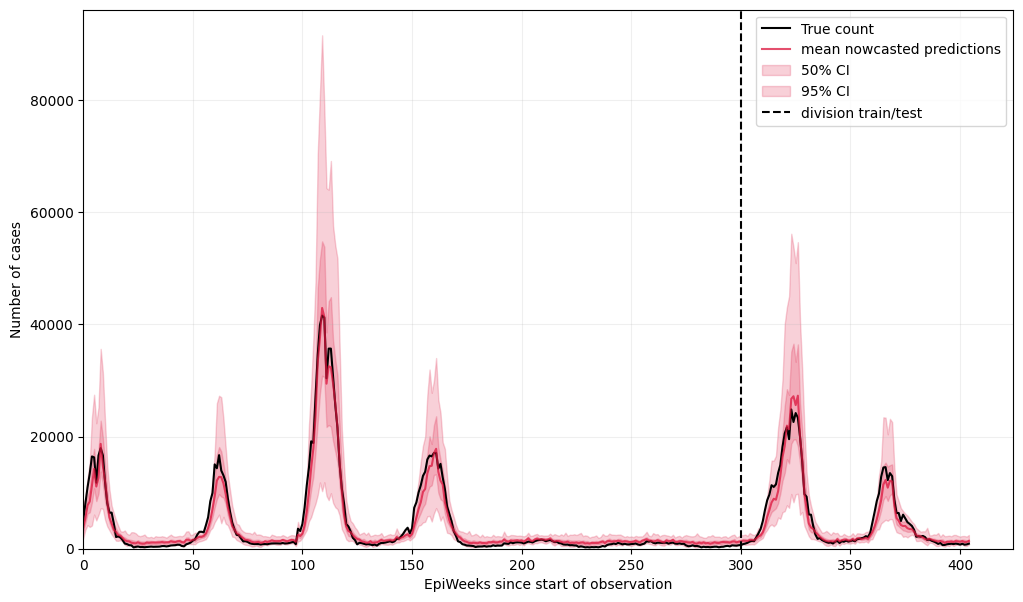

In [487]:
%reload_ext autoreload
%autoreload 3
from plotting import plot_entire_confints
plot_entire_confints(dataset, bayes_nowcaster)

### Test sampling from negative binomial, check if implementation works

Wrote class, compare to other implementations (have equivalences of params), plot output

Theoretical mean in parameterization: tensor([40000.]), highest log-prob at 1176


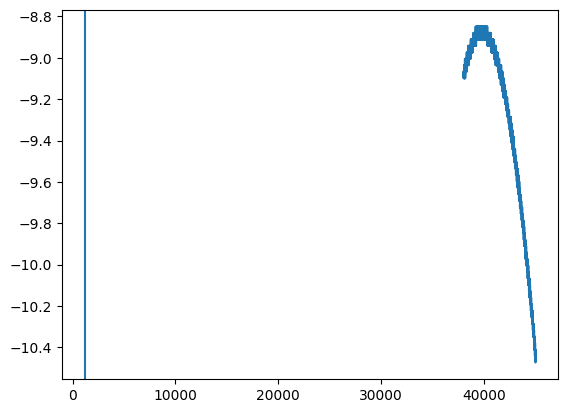

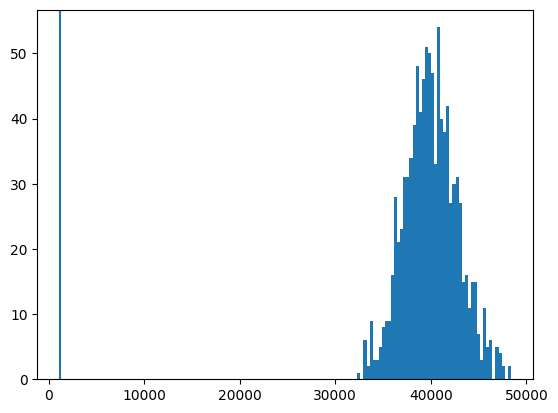

In [401]:
import torch
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 3

# r(1-p)/p = lbda | r = phi  <==> phi(1-p)/p = lbda <==> (1)/p = lbda/phi+1 <==> 

## Define lbda, phi, r and p
#r, p = 750, 0.25 # here p as prob of success
mean, overdisp = 40000, 200
r, p = overdisp, 1/(mean/overdisp+1)
lbda, phi = torch.Tensor([mean]), torch.Tensor([overdisp])
## Sample
from NegativeBinomial import NegBin

negbin = NegBin(lbda=lbda, phi=phi)
log_probs = negbin.log_prob(torch.arange(38000, 45000))
log_max = torch.argmax(log_probs)

from numpy.random import negative_binomial
samples = negative_binomial(r, p, size = 1000)#negbin.sample()

print(f"Theoretical mean in parameterization: {lbda}, highest log-prob at {log_max}")
## Plot
plt.plot(range(38000, 45000), log_probs)
plt.axvline(log_max)
plt.show()

plt.hist(samples, bins = 50)
plt.axvline(log_max)
plt.show()

In [47]:
lbda

tensor([300.])

## Forecasting/outbreak warning
Given that always single value predicted, can update current data and form next prediction and thus forecast days/weeks into the future. Moreover, try to find "peak" of outbreak and maybe assess likelihood of outbreak.

Apart from that, variance should go up on each step, so could e.g. sample current prediction and then continue with empirical bounds, BUT if continue to sample at each future step grows exponentially

Seems like once crosses 2-3k cases, outbreak occurs, so could sample from forecast and then return proportion higher than 2-3k as probability of outbreak occuring within forecast horizon. Alternatively, could look at change in cases over previous mean and if exceeds boundary classify as outbreak

EWMA, tune parameters to not include small fluctuations

## Peak prediction

Useful to be able to predict when peak of cases is reached, so resources can be planned/distributed. Could theoretically draw many times and just continue with random draw and then plot all curves, along with distribution of peak values.

In [176]:
for j in range(25):
    print(f"Int j={j}, j//5 = {j//5}, j%5 = {j%5}, j%5 > (md=)4-j//5 {bool(j%5 > 4-j//5)}")

Int j=0, j//5 = 0, j%5 = 0, j%5 > (md=)4-j//5 False
Int j=1, j//5 = 0, j%5 = 1, j%5 > (md=)4-j//5 False
Int j=2, j//5 = 0, j%5 = 2, j%5 > (md=)4-j//5 False
Int j=3, j//5 = 0, j%5 = 3, j%5 > (md=)4-j//5 False
Int j=4, j//5 = 0, j%5 = 4, j%5 > (md=)4-j//5 False
Int j=5, j//5 = 1, j%5 = 0, j%5 > (md=)4-j//5 False
Int j=6, j//5 = 1, j%5 = 1, j%5 > (md=)4-j//5 False
Int j=7, j//5 = 1, j%5 = 2, j%5 > (md=)4-j//5 False
Int j=8, j//5 = 1, j%5 = 3, j%5 > (md=)4-j//5 False
Int j=9, j//5 = 1, j%5 = 4, j%5 > (md=)4-j//5 True
Int j=10, j//5 = 2, j%5 = 0, j%5 > (md=)4-j//5 False
Int j=11, j//5 = 2, j%5 = 1, j%5 > (md=)4-j//5 False
Int j=12, j//5 = 2, j%5 = 2, j%5 > (md=)4-j//5 False
Int j=13, j//5 = 2, j%5 = 3, j%5 > (md=)4-j//5 True
Int j=14, j//5 = 2, j%5 = 4, j%5 > (md=)4-j//5 True
Int j=15, j//5 = 3, j%5 = 0, j%5 > (md=)4-j//5 False
Int j=16, j//5 = 3, j%5 = 1, j%5 > (md=)4-j//5 False
Int j=17, j//5 = 3, j%5 = 2, j%5 > (md=)4-j//5 True
Int j=18, j//5 = 3, j%5 = 3, j%5 > (md=)4-j//5 True
Int j=19